In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import XYZ_to_Lab, delta_E, XYZ_to_RGB, RGB_to_XYZ
from colour.models import RGB_COLOURSPACE_sRGB
import tifffile
import zarr
from colour_lib.circle_process.rawparser import RawDataParser
from colour_lib.circle_process.circlelib import CircleColors

In [2]:
global_dir = '/uftp/src/'
rw = RawDataParser(reference_basepath = f'{global_dir}calibration_data/')
circ = CircleColors()

In [6]:
def image_read(sector, g1, g2, g3):
  store = tifffile.imread(f'{global_dir}Calib_{sector}_{g1}_{g2}_{g3}_202402.tif', aszarr=True)
  zarr_pyramids = zarr.open(store, mode='r')
  image = np.array(zarr_pyramids[3])/255
  image_revert = circ.get_reverted_gammaCorr(image,[(g1/10),(g2/10),(g3/10)])
  return image_revert

In [7]:
def coords_read(sz):
  return pd.read_csv(f'{global_dir}saved_coords/manual/huron0224/{sz}um_coords.csv')

In [8]:
images = {
    "R1_111": image_read("R1", 10, 10, 10)
}
rads = {"4150":40, "1000":10, "750":6, "500":4, "400":4, "300":2, "250":2, "200":1, "150":1, "CA1000":50}
coords = {"4150":coords_read(4150),
          "1000":coords_read(1000),
          "750":coords_read(750),
          "500":coords_read(500),
          "400":coords_read(400),
          "300":coords_read(300),
          "250":coords_read(250),
          "200":coords_read(200),
          "150":coords_read(150),
          "CA1000":coords_read("CA1000")}
number_of_circles = 24

<tifffile.TiffPage 6 @11318147692> missing data offset tag


In [9]:
def draw_circle_mask(image, coord, radius):
  mask_shape = image.shape
  coords_y, coords_x = np.ogrid[: mask_shape[0], : mask_shape[1]]
  circle_mask = np.zeros(mask_shape[:2], dtype=bool)
  for idx, centroids in coord.iterrows():
      centroid_y, centroid_x = centroids["Y"], centroids["X"]
      circle_mask = circle_mask | ((coords_y - centroid_y) ** 2 + (coords_x - centroid_x) ** 2 <= radius**2)

  plt.imshow(image)
  plt.imshow(circle_mask, alpha=0.5)

In [15]:
CA = circ.calc_rectangle(images["R1_111"],
               coords["CA1000"],
               rads["CA1000"])
slide = circ.calc_rectangles(images["R1_111"],
                        coords,
                        rads,
                        zones = ["1000", "750", "500", "400", "300", "250", "200", "150"])

/tmp/ipykernel_14297/2390175713.py:10: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
colour_arrays = {
    "exp_srgbs": circ.calc_slide(CA,slide),
    "exp_xyz": RGB_to_XYZ(circ.calc_slide(CA,slide), RGB_COLOURSPACE_sRGB), #not correct
    "ref_srgbs": rw.get_reference_srgbs(),
    "ref_xyz": rw.get_reference_d65()
}

In [21]:
from colour_lib.regressors.PLSregressor import PLSRegressor
from colour_lib.regressors.LassoRegressor import LassoRegressor

In [22]:
PLS_reg = PLSRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"])
Lasso_reg = LassoRegressor(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"], 0.01)

In [23]:
images["HS1 PLS reg"] = PLS_reg.predict(images["R1_111"])
images["HS1 Lasso reg"] = Lasso_reg.predict(images["R1_111"])

In [24]:
CA = circ.calc_rectangle(images["HS1 PLS reg"],
               coords["CA1000"],
               rads["CA1000"])
slide = circ.calc_rectangle(images["HS1 PLS reg"],
               coords["1000"],
               rads["1000"])
colour_arrays["PLS_reg_srgbs"] = circ.calc_slide(CA,slide)
CA = circ.calc_rectangle(images["HS1 Lasso reg"],
               coords["CA1000"],
               rads["CA1000"])
slide = circ.calc_rectangle(images["HS1 Lasso reg"],
               coords["1000"],
               rads["1000"])
colour_arrays["Lasso_reg_srgbs"] = circ.calc_slide(CA,slide)

/tmp/ipykernel_14297/2390175713.py:10: RuntimeWarning: Mean of empty slice.
  mean_in_circle.append(channel_values.mean())
/home/gboykov/GBvenv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


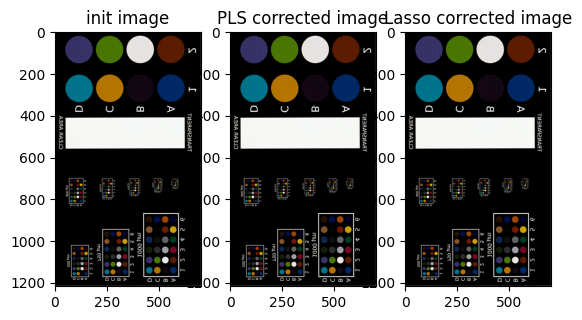

In [25]:
name_list = [["R1_111", "init image"],
             ["HS1 PLS reg", "PLS corrected image"],
             ["HS1 Lasso reg", "Lasso corrected image"]]

f, axarr = plt.subplots(1,3)
for i, vector in enumerate(name_list):
  axarr[i].imshow(images[vector[0]])
  axarr[i].set_title(vector[1])

In [26]:
np.mean(circ.calculate_delta_E(colour_arrays["exp_srgbs"], colour_arrays["ref_srgbs"]))

21.43061952411399

In [27]:
np.mean(circ.calculate_delta_E(colour_arrays["PLS_reg_srgbs"], colour_arrays["ref_srgbs"]))

22.07711729510174

In [28]:
np.mean(circ.calculate_delta_E(colour_arrays["Lasso_reg_srgbs"], colour_arrays["ref_srgbs"]))

22.07711729510174